# Twitter Semantic Analysis

In [2]:
!pip install emoji

     -------------------------------------- 358.9/358.9 kB 1.4 MB/s eta 0:00:00


Business Objective: 1. Need to get sentiment analysis of tweets gauge its impact and typeArchitecture level analysis.

2.Data transformation/Text processing using R/Python

3.Need to get sentiments Analysis and Emotion mining with some charts like histogram, Density plot, Barplot, pie-plot etc.

4.Deployment through R Shiny or Flask/ Streamlit

In [3]:
# General Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords= nltk.corpus.stopwords.words('english')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#Bert Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from scipy.special import softmax

#LMST
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
df=pd.read_csv('tweet.csv')

In [5]:
df.head()

,tweets,class
0,Be aware dirty step to get money #staylight ...,figurative
1,#sarcasm for #people who don't understand #diy...,figurative
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative
3,@wilw Why do I get the feeling you like games?...,figurative
4,-@TeacherArthurG @rweingarten You probably jus...,figurative


# Exploratory data analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81408 entries, 0 to 81407
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  81408 non-null  object
 1   class   81408 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
df.shape

(81408, 2)

In [8]:
df.isnull().sum()

tweets    0
class     0
dtype: int64

In [9]:
df.duplicated().sum()

49

In [10]:
df=df.drop_duplicates()

In [11]:
df.duplicated().sum()

0

In [12]:
df['class'].unique()

array(['figurative', 'irony', 'regular', 'sarcasm'], dtype=object)

In [13]:
#Tweets count by class
df['class'].value_counts()

figurative    21235
irony         20877
sarcasm       20678
regular       18569
Name: class, dtype: int64

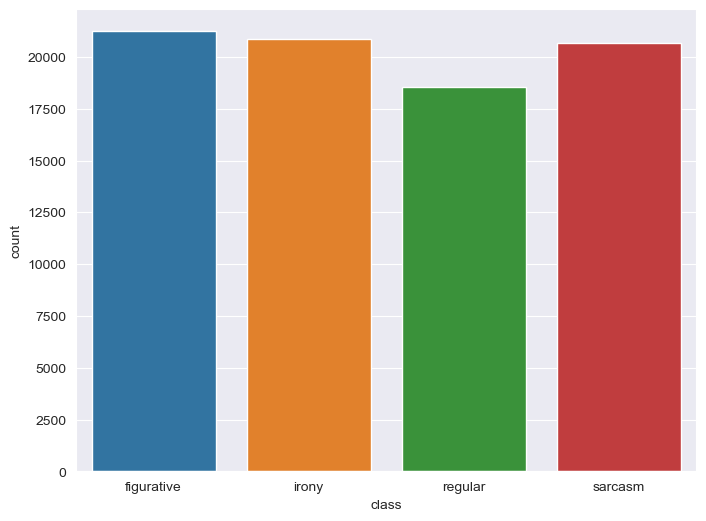

In [14]:
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.countplot(x=df['class'])
plt.show()


# Tweets Cleaning

In [15]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

def strip_emoji(text):
    return RE_EMOJI.sub(r'', text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [16]:
texts_new = []
for t in df.tweets:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [17]:
df['text_clean'] = texts_new
df.head()

,tweets,class,text_clean
0,Be aware dirty step to get money #staylight ...,figurative,be aware dirty step to get money staylight sta...
1,#sarcasm for #people who don't understand #diy...,figurative,sarcasm for people who dont understand diy art...
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,dailymail readers being sensible as always sho...
3,@wilw Why do I get the feeling you like games?...,figurative,why do i get the feeling you like games sarcasm
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,you probably just missed the text sarcastic


In [18]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [19]:
df['text_len'] = text_len
df.head()

,tweets,class,text_clean,text_len
0,Be aware dirty step to get money #staylight ...,figurative,be aware dirty step to get money staylight sta...,11
1,#sarcasm for #people who don't understand #diy...,figurative,sarcasm for people who dont understand diy art...,8
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,dailymail readers being sensible as always sho...,11
3,@wilw Why do I get the feeling you like games?...,figurative,why do i get the feeling you like games sarcasm,10
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,you probably just missed the text sarcastic,7


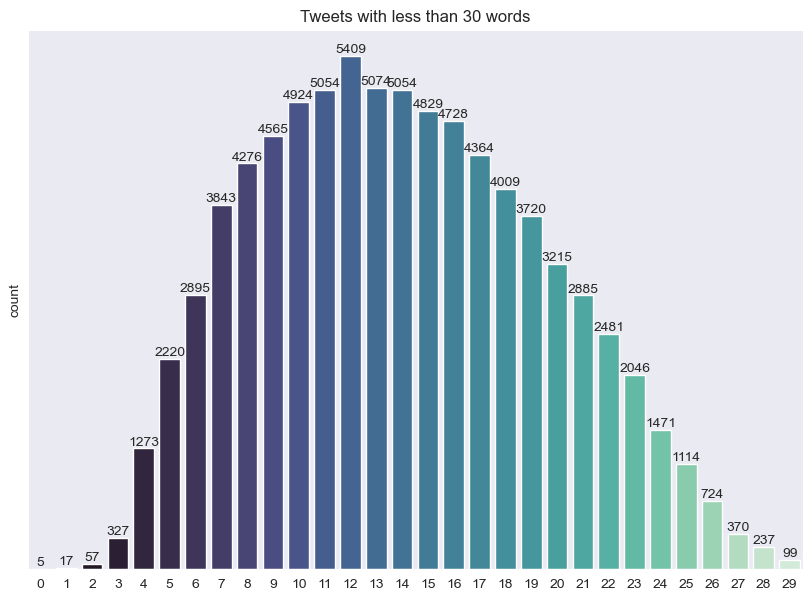

In [20]:
plt.figure(figsize=(10,7))
ax = sns.countplot(x='text_len', data=df[df['text_len']<30], palette='mako')
plt.title('Tweets with less than 30 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

# Class cloumn Analysis

In [21]:
df['class']=df['class'].map({'figurative':0, 'irony':1, 'sarcasm':2, 'regular':3})

In [22]:
df.head()

,tweets,class,text_clean,text_len
0,Be aware dirty step to get money #staylight ...,0,be aware dirty step to get money staylight sta...,11
1,#sarcasm for #people who don't understand #diy...,0,sarcasm for people who dont understand diy art...,8
2,@IminworkJeremy @medsingle #DailyMail readers ...,0,dailymail readers being sensible as always sho...,11
3,@wilw Why do I get the feeling you like games?...,0,why do i get the feeling you like games sarcasm,10
4,-@TeacherArthurG @rweingarten You probably jus...,0,you probably just missed the text sarcastic,7


In [23]:
# Tokenization
def tokenize_text(text):
    return word_tokenize(text)
df['tokens']=df['text_clean'].apply(tokenize_text)

#Stopwords Removal
def cleaning_stopwords(token):
    return " ".join([word for word in str(token).split() if word not in stopwordS])
    data1['tokens'].apply(lambda k: cleaning_stopwords(k))
    
# Stemming
def stem_text(tokens):
    ps=PorterStemmer()
    return " ".join([ps.stem(token) for token in tokens])
df['stem']=df['tokens'].apply(stem_text)

# Lemmatization
def lemmatize_text(tokens):
    lm=WordNetLemmatizer()
    return " ".join([lm.lemmatize(token,pos='v') for token in tokens])
df['lem']=df['tokens'].apply(lemmatize_text)
df.head()

,tweets,class,text_clean,text_len,tokens,stem,lem
0,Be aware dirty step to get money #staylight ...,0,be aware dirty step to get money staylight sta...,11,"[be, aware, dirty, step, to, get, money, stayl...",be awar dirti step to get money staylight stay...,be aware dirty step to get money staylight sta...
1,#sarcasm for #people who don't understand #diy...,0,sarcasm for people who dont understand diy art...,8,"[sarcasm, for, people, who, dont, understand, ...",sarcasm for peopl who dont understand diy arta...,sarcasm for people who dont understand diy art...
2,@IminworkJeremy @medsingle #DailyMail readers ...,0,dailymail readers being sensible as always sho...,11,"[dailymail, readers, being, sensible, as, alwa...",dailymail reader be sensibl as alway shocker s...,dailymail readers be sensible as always shocke...
3,@wilw Why do I get the feeling you like games?...,0,why do i get the feeling you like games sarcasm,10,"[why, do, i, get, the, feeling, you, like, gam...",whi do i get the feel you like game sarcasm,why do i get the feel you like game sarcasm
4,-@TeacherArthurG @rweingarten You probably jus...,0,you probably just missed the text sarcastic,7,"[you, probably, just, missed, the, text, sarca...",you probabl just miss the text sarcast,you probably just miss the text sarcastic


# Visualizations

Text(0.5, 1.0, 'WordCloud - regular class')

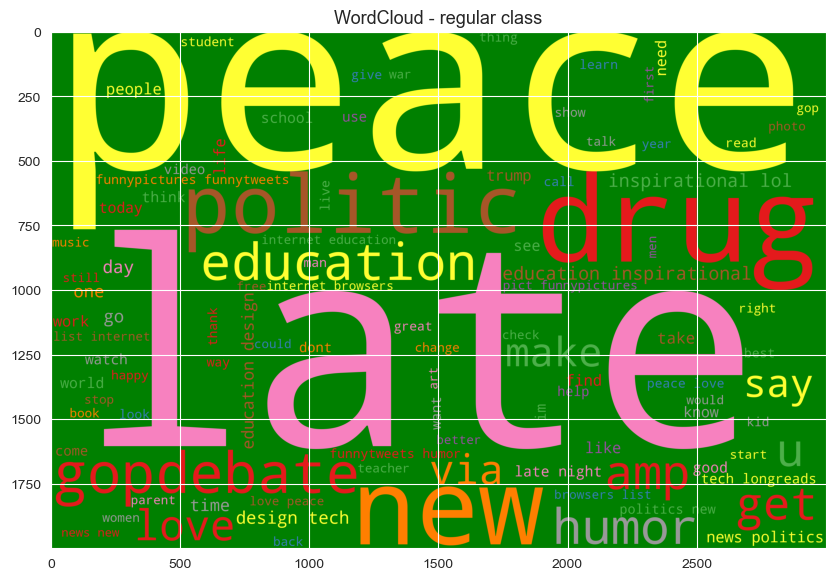

In [24]:
plt.figure(figsize=(10,8))
text =' '.join([text for text in df['lem'][df['class'] == 3]])
wc = WordCloud(width = 3000, height = 2000, background_color = 'green', max_words = 100,
                   colormap = 'Set1',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.title("WordCloud - regular class", fontsize = 13)

Text(0.5, 1.0, 'WordCloud - irony class')

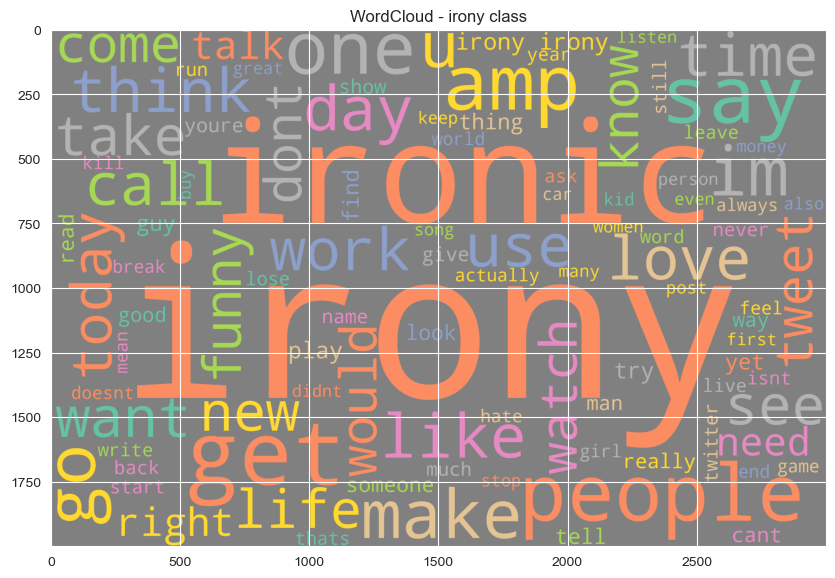

In [26]:
plt.figure(figsize=(10,8))
text =' '.join([text for text in df['lem'][df['class'] == 1]])
wc = WordCloud(width = 3000, height = 2000, background_color = 'gray', max_words = 100,
                   colormap = 'Set2',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.title("WordCloud - irony class", fontsize = 12)

Text(0.5, 1.0, 'WordCloud - sarcasm class')

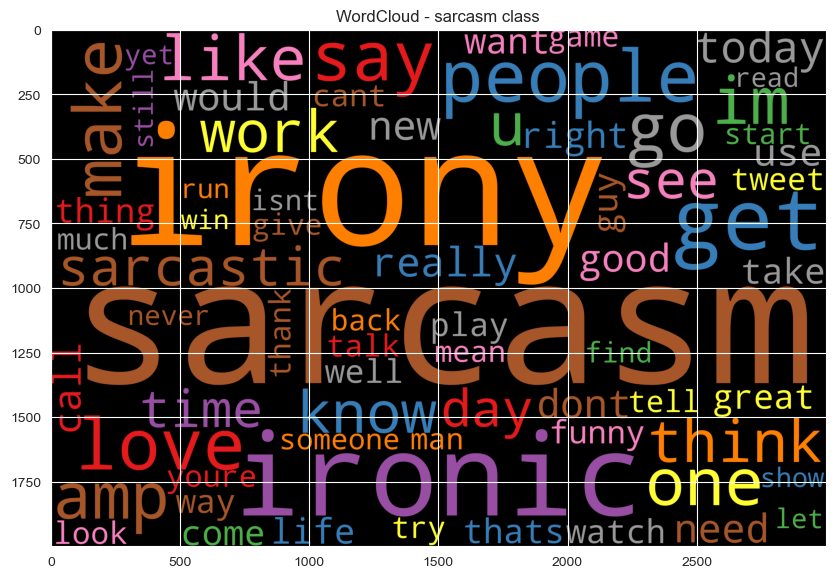

In [27]:
plt.figure(figsize=(10,8))
text =' '.join([text for text in df['lem'][df['class'] == 0]])
wc = WordCloud(width = 3000, height = 2000, background_color = 'Black', max_words = 70,
                   colormap = 'Set1',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.title("WordCloud - sarcasm class", fontsize = 12)

Text(0.5, 1.0, 'WordCloud - figurative class')

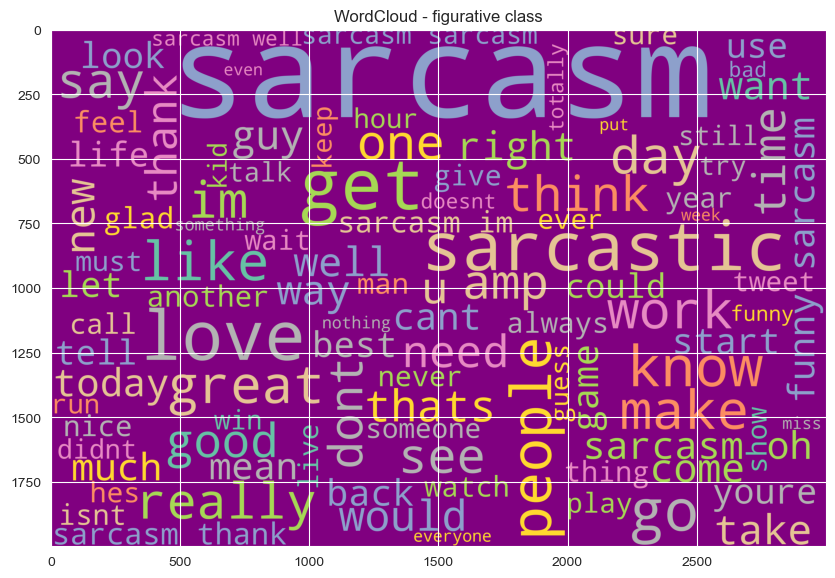

In [28]:
plt.figure(figsize=(10,8))
text =' '.join([text for text in df['lem'][df['class'] == 2]])
wc = WordCloud(width = 3000, height = 2000, background_color = 'purple', max_words = 100,
                   colormap = 'Set2',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.title("WordCloud - figurative class", fontsize = 12)

# Feature Extraction 

In [29]:
vector=TfidfVectorizer(max_features=2000)
x=vector.fit_transform(df['lem'])
x=x.toarray()

In [30]:
vector.vocabulary_

{'be': 173,
 'dirty': 502,
 'step': 1642,
 'to': 1779,
 'get': 738,
 'money': 1133,
 'sarcastic': 1486,
 'sarcasm': 1485,
 'for': 694,
 'people': 1266,
 'who': 1925,
 'dont': 517,
 'understand': 1839,
 'as': 129,
 'always': 80,
 'shocker': 1545,
 'why': 1929,
 'do': 510,
 'the': 1740,
 'feel': 650,
 'you': 1986,
 'like': 1023,
 'game': 728,
 'probably': 1348,
 'just': 962,
 'miss': 1125,
 'text': 1734,
 'tune': 1822,
 'in': 894,
 'and': 91,
 'treat': 1805,
 'fight': 658,
 'song': 1603,
 'move': 1146,
 'amp': 88,
 'local': 1037,
 'irony': 936,
 'what': 1915,
 'dc': 459,
 'love': 1053,
 'man': 1068,
 'wish': 1941,
 'could': 407,
 'an': 90,
 'not': 1189,
 'go': 746,
 'jail': 946,
 'car': 285,
 'ride': 1454,
 'when': 1918,
 'listen': 1030,
 'whole': 1926,
 'time': 1774,
 'yeah': 1975,
 'cant': 283,
 'wait': 1877,
 'either': 562,
 'call': 271,
 'best': 190,
 'movie': 1147,
 'yet': 1982,
 'decide': 466,
 'whether': 1920,
 'its': 943,
 'or': 1229,
 'sorry': 1608,
 'my': 1158,
 'dark': 451,
 '

In [31]:
x.shape

(81359, 2000)

In [32]:
y=df["class"].values
y

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [33]:
#Training And Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=2)

# Deep Learning Models

# BERT Model

In [34]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

D:\anaconda softwere\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usee\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [35]:
token=tokenizer.encode('I love this food ', return_tensors='pt')

In [36]:
token

tensor([[  101,   151, 11157, 10372, 15225,   102]])

In [37]:
result=model(token)

In [38]:
result.logits

tensor([[-2.3256, -2.5355, -0.9543,  1.4597,  3.5020]],
       grad_fn=<AddmmBackward0>)

In [39]:
score=int(torch.argmax(result.logits))+1

In [40]:
score

5

In [41]:
def sentiment_score(tweet):
    token=tokenizer.encode(tweet, return_tensors='pt')
    result=model(token)
    result.logits
    return int(torch.argmax(result.logits))+1

In [42]:
sentiment_score(df['text_clean'][4])

2

In [43]:
sentiment_score("This is very good product")

5

In [44]:
sentiment_score(df['text_clean'][20])

5

In [ ]:
df['se_score']=df['text_clean'].apply(lambda x: sentiment_score(x))

In [160]:
df

,tweets,class,text_clean,text_len,tokens,stem,lem,se_score
0,Be aware dirty step to get money #staylight ...,0,be aware dirty step to get money staylight sta...,11,"[be, aware, dirty, step, to, get, money, stayl...",be awar dirti step to get money staylight stay...,be aware dirty step to get money staylight sta...,1
1,#sarcasm for #people who don't understand #diy...,0,sarcasm for people who dont understand diy art...,8,"[sarcasm, for, people, who, dont, understand, ...",sarcasm for peopl who dont understand diy arta...,sarcasm for people who dont understand diy art...,1
2,@IminworkJeremy @medsingle #DailyMail readers ...,0,dailymail readers being sensible as always sho...,11,"[dailymail, readers, being, sensible, as, alwa...",dailymail reader be sensibl as alway shocker s...,dailymail readers be sensible as always shocke...,1
3,@wilw Why do I get the feeling you like games?...,0,why do i get the feeling you like games sarcasm,10,"[why, do, i, get, the, feeling, you, like, gam...",whi do i get the feel you like game sarcasm,why do i get the feel you like game sarcasm,1
4,-@TeacherArthurG @rweingarten You probably jus...,0,you probably just missed the text sarcastic,7,"[you, probably, just, missed, the, text, sarca...",you probabl just miss the text sarcast,you probably just miss the text sarcastic,2
...,...,...,...,...,...,...,...,...
81403,Photo: Image via We Heart It http://t.co/ky8Nf...,2,photo image via we heart it childhood cool fun...,10,"[photo, image, via, we, heart, it, childhood, ...",photo imag via we heart it childhood cool funn...,photo image via we heart it childhood cool fun...,5
81404,I never knew..I better put this out to the Uni...,2,i never knewi better put this out to the unive...,20,"[i, never, knewi, better, put, this, out, to, ...",i never knewi better put thi out to the univer...,i never knewi better put this out to the unive...,1
81405,hey just wanted to say thanks @ puberty for le...,2,hey just wanted to say thanks puberty for lett...,23,"[hey, just, wanted, to, say, thanks, puberty, ...",hey just want to say thank puberti for let me ...,hey just want to say thank puberty for let me ...,1
81406,I'm sure coverage like the Fox News Special “T...,2,im sure coverage like the fox news special the...,18,"[im, sure, coverage, like, the, fox, news, spe...",im sure coverag like the fox news special the ...,im sure coverage like the fox news special the...,1


In [161]:
Kdf=df.copy()

In [162]:
Kdf.head()

,tweets,class,text_clean,text_len,tokens,stem,lem,se_score
0,Be aware dirty step to get money #staylight ...,0,be aware dirty step to get money staylight sta...,11,"[be, aware, dirty, step, to, get, money, stayl...",be awar dirti step to get money staylight stay...,be aware dirty step to get money staylight sta...,1
1,#sarcasm for #people who don't understand #diy...,0,sarcasm for people who dont understand diy art...,8,"[sarcasm, for, people, who, dont, understand, ...",sarcasm for peopl who dont understand diy arta...,sarcasm for people who dont understand diy art...,1
2,@IminworkJeremy @medsingle #DailyMail readers ...,0,dailymail readers being sensible as always sho...,11,"[dailymail, readers, being, sensible, as, alwa...",dailymail reader be sensibl as alway shocker s...,dailymail readers be sensible as always shocke...,1
3,@wilw Why do I get the feeling you like games?...,0,why do i get the feeling you like games sarcasm,10,"[why, do, i, get, the, feeling, you, like, gam...",whi do i get the feel you like game sarcasm,why do i get the feel you like game sarcasm,1
4,-@TeacherArthurG @rweingarten You probably jus...,0,you probably just missed the text sarcastic,7,"[you, probably, just, missed, the, text, sarca...",you probabl just miss the text sarcast,you probably just miss the text sarcastic,2


In [163]:
    MAX_L=max(df['text_len'])
    MAX_L

34

In [166]:
Kdf['se_score'].value_counts()

1    36220
5    23516
3     9700
4     7316
2     4607
Name: se_score, dtype: int64

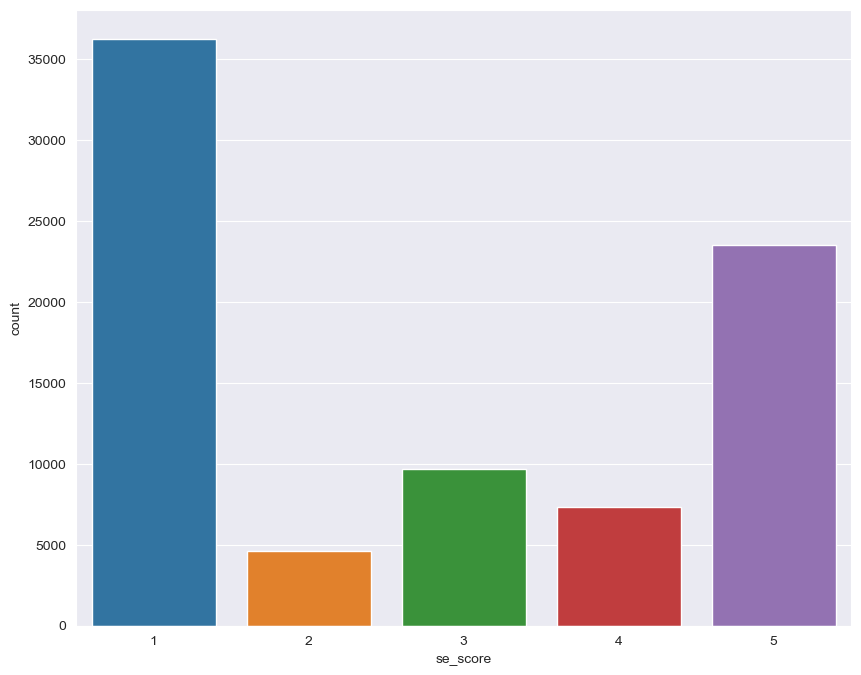

In [169]:
plt.figure(figsize=(10,8))
sns.countplot(x=Kdf['se_score'])
plt.show()

# Roberta Model

In [170]:
MODEL=f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model2=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [175]:
encode=tokenizer(Kdf['text_clean'][55], return_tensors='pt')

In [176]:
encode

{'input_ids': tensor([[    0, 14746,   939,   524,  4904,    50,  8164,   127, 39580,  4166,
           555,   112, 47879,   139,  3023,    29,    55,  4353,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [177]:
rr=model2(**encode)

In [178]:
rr

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.4078,  0.1359, -2.6808]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [179]:
scores=rr[0][0].detach().numpy()
scores

array([ 2.4077926,  0.1359063, -2.6808436], dtype=float32)

In [180]:
scores=softmax(scores)

In [181]:
scores

array([0.90148246, 0.0929586 , 0.00555892], dtype=float32)

In [182]:
def roberta_scores(tweet):
    encode=tokenizer(tweet, return_tensors='pt')
    rr=model2(**encode)
    scores=rr[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={'Positive':scores[2],
                'Neutral':scores[1],
                'Negitive':scores[0]}
    return scores_dict

In [183]:
roberta_scores('this is a very bad product')

{'Positive': 0.0025885892, 'Neutral': 0.019746076, 'Negitive': 0.9776653}

In [184]:
Kdf['text_clean'][1]

'sarcasm for people who dont understand diy artattack'

In [185]:
roberta_scores(Kdf['text_clean'][1])

{'Positive': 0.0138292685, 'Neutral': 0.1912591, 'Negitive': 0.79491156}

In [186]:
#Apply the model to entire of data
df['id']=range(1,81360)

In [187]:
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):
    tweet=row['text_clean']
    myid=row['id']
    res[myid]=roberta_scores(tweet)

  0%|          | 0/81359 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [69]:
roberta=pd.DataFrame(res).T

In [70]:
roberta=roberta.reset_index().rename(columns={'index':'id'})
roberta=roberta.merge(df, how='left')

In [71]:
roberta

,id,Positive,Neutral,Negitive,tweets,class,text_clean,text_len,tokens,stem,lem,se_score
0,1,0.316248,0.622092,0.061659,Be aware dirty step to get money #staylight ...,0,be aware dirty step to get money staylight sta...,11,"[be, aware, dirty, step, to, get, money, stayl...",be awar dirti step to get money staylight stay...,be aware dirty step to get money staylight sta...,1
1,2,0.794912,0.191259,0.013829,#sarcasm for #people who don't understand #diy...,0,sarcasm for people who dont understand diy art...,8,"[sarcasm, for, people, who, dont, understand, ...",sarcasm for peopl who dont understand diy arta...,sarcasm for people who dont understand diy art...,1
2,3,0.515455,0.423809,0.060735,@IminworkJeremy @medsingle #DailyMail readers ...,0,dailymail readers being sensible as always sho...,11,"[dailymail, readers, being, sensible, as, alwa...",dailymail reader be sensibl as alway shocker s...,dailymail readers be sensible as always shocke...,1
3,4,0.738022,0.246689,0.015289,@wilw Why do I get the feeling you like games?...,0,why do i get the feeling you like games sarcasm,10,"[why, do, i, get, the, feeling, you, like, gam...",whi do i get the feel you like game sarcasm,why do i get the feel you like game sarcasm,1
4,5,0.578396,0.395011,0.026593,-@TeacherArthurG @rweingarten You probably jus...,0,you probably just missed the text sarcastic,7,"[you, probably, just, missed, the, text, sarca...",you probabl just miss the text sarcast,you probably just miss the text sarcastic,2
...,...,...,...,...,...,...,...,...,...,...,...,...
81354,81355,0.002454,0.056130,0.941417,Photo: Image via We Heart It http://t.co/ky8Nf...,2,photo image via we heart it childhood cool fun...,10,"[photo, image, via, we, heart, it, childhood, ...",photo imag via we heart it childhood cool funn...,photo image via we heart it childhood cool fun...,5
81355,81356,0.045313,0.409318,0.545368,I never knew..I better put this out to the Uni...,2,i never knewi better put this out to the unive...,20,"[i, never, knewi, better, put, this, out, to, ...",i never knewi better put thi out to the univer...,i never knewi better put this out to the unive...,1
81356,81357,0.040495,0.090912,0.868593,hey just wanted to say thanks @ puberty for le...,2,hey just wanted to say thanks puberty for lett...,23,"[hey, just, wanted, to, say, thanks, puberty, ...",hey just want to say thank puberti for let me ...,hey just want to say thank puberty for let me ...,1
81357,81358,0.278480,0.657513,0.064007,I'm sure coverage like the Fox News Special “T...,2,im sure coverage like the fox news special the...,18,"[im, sure, coverage, like, the, fox, news, spe...",im sure coverag like the fox news special the ...,im sure coverage like the fox news special the...,1


In [196]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
# Define the RoBERTa tokenizer and load the pre-trained model
tokenizer7 = RobertaTokenizer.from_pretrained('roberta-base')
model7 = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

# Tokenize the text data and convert to PyTorch tensors
X = list(Kdf['tweets'])
y = list(Kdf['se_score'])  # Replace 'sentiment_numeric' with your numeric label column

# Tokenize and convert to tensors
inputs = tokenizer(X, padding=True, truncation=True, return_tensors='pt', max_length=128)
labels = torch.tensor(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs.input_ids, labels, test_size=0.2, random_state=42)

# Define the optimizer and loss function
optimizer = AdamW(model7.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
epochs = 5
for epoch in range(epochs):
    model7.train()
    optimizer.zero_grad()
    outputs = model(X_train, labels=y_train)
    loss = loss_fn(outputs.logits, y_train)
    loss.backward()
    optimizer.step()

# Evaluation
model7.eval()
with torch.no_grad():
    outputs = model7(X_test)
    predictions = np.argmax(outputs.logits, axis=1)
    accuracy = accuracy_score(y_test.numpy(), predictions)

print(f'Accuracy: {accuracy}')


KeyboardInterrupt: 

# LMST Model

In [190]:

# Preprocess the text data
tokenizer3 = Tokenizer(num_words=5000)
tokenizer3.fit_on_texts(Kdf['text_clean'])
X = tokenizer3.texts_to_sequences(Kdf['text_clean'])
X = pad_sequences(X)

# Convert numeric sentiment labels to numpy arrays
y = np.array(Kdf['se_score'])  # Replace 'sentiment_numeric' with your numeric label column
y = to_categorical(y - 1, num_classes=5)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build an LSTM-based sentiment analysis model with 5 output units
model5 = Sequential()
model5.add(Embedding(input_dim=5000, output_dim=128, input_length=X.shape[1]))
model5.add(LSTM(128))
model5.add(Dense(5, activation='softmax'))  # 5 output classes (1 to 5)

model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model5.fit(X_train, y_train, epochs=5, batch_size=2, validation_split=0.2)

# Evaluate the model
loss, accuracy = model5.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/5
26035/26035 [==============================] - 381s 15ms/step - loss: 0.9615 - accuracy: 0.6371 - val_loss: 0.8567 - val_accuracy: 0.6738
Epoch 2/5
26035/26035 [==============================] - 313s 12ms/step - loss: 0.7547 - accuracy: 0.7156 - val_loss: 0.8291 - val_accuracy: 0.6865
Epoch 3/5
26035/26035 [==============================] - 317s 12ms/step - loss: 0.6463 - accuracy: 0.7600 - val_loss: 0.8443 - val_accuracy: 0.6864
Epoch 4/5
26035/26035 [==============================] - 519s 20ms/step - loss: 0.5472 - accuracy: 0.7988 - val_loss: 0.8738 - val_accuracy: 0.6924
Epoch 5/5
509/509 [==============================] - 3s 5ms/step - loss: 0.9210 - accuracy: 0.6825
Loss: 0.9210353493690491, Accuracy: 0.6825221180915833


# Machine Learning Models

# Naive Bias Model

In [35]:
#Training And Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=2)

In [36]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

In [37]:
gnb=GaussianNB() # Gaussian naive bayes object
mnb=MultinomialNB() # Multinomal naive bayes object
bnb=BernoulliNB() # Bernoulli naive bayes object

In [38]:
# Gaussian naive bayes algorithm 

gnb.fit(x_train,y_train)
y_pred1=gnb.predict(x_test)
acc1=accuracy_score(y_test,y_pred1)
cm1=confusion_matrix(y_test,y_pred1)
cr1=classification_report(y_test,y_pred1)
print(cr1)

              precision    recall  f1-score   support

           0       0.30      0.27      0.28      4255
           1       0.57      0.61      0.59      4205
           2       0.58      0.76      0.65      4156
           3       0.98      0.68      0.81      3656

    accuracy                           0.57     16272
   macro avg       0.61      0.58      0.58     16272
weighted avg       0.59      0.57      0.57     16272



In [39]:
# Multinomal naive bayes algorithm

mnb.fit(x_train,y_train)
y_pred2=mnb.predict(x_test)
acc2=accuracy_score(y_test,y_pred2)
cm2=confusion_matrix(y_test,y_pred2)
cr2=classification_report(y_test,y_pred2)
print(cr2)

              precision    recall  f1-score   support

           0       0.31      0.25      0.28      4255
           1       0.63      0.70      0.66      4205
           2       0.63      0.71      0.66      4156
           3       0.94      0.88      0.91      3656

    accuracy                           0.62     16272
   macro avg       0.63      0.63      0.63     16272
weighted avg       0.62      0.62      0.62     16272



In [40]:
# Bernoulli naive bayes

bnb.fit(x_train,y_train)
y_pred3=bnb.predict(x_test)
acc3=accuracy_score(y_test,y_pred3)
cm3=confusion_matrix(y_test,y_pred3)
cr3=classification_report(y_test,y_pred3)
print(cr3)

              precision    recall  f1-score   support

           0       0.29      0.10      0.15      4255
           1       0.66      0.89      0.76      4205
           2       0.65      0.89      0.75      4156
           3       1.00      0.95      0.97      3656

    accuracy                           0.70     16272
   macro avg       0.65      0.71      0.66     16272
weighted avg       0.64      0.70      0.65     16272



In [42]:
clfs = {
    'Gaussian NB' : gnb,
    'Multinomal NB' : mnb, 
    'Bernoulli NB': bnb,  
}
accuracy_scores = [acc1,acc2,acc3]

In [43]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores}).sort_values('Accuracy',ascending=False)

In [44]:
performance_df

,Algorithm,Accuracy
2,Bernoulli NB,0.696411
1,Multinomal NB,0.624693
0,Gaussian NB,0.573992


# Deployment part

In [1]:
# Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from scipy.special import softmax

In [4]:
# Pre _ train the model with corpus 
MODEL=f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model2=AutoModelForSequenceClassification.from_pretrained(MODEL)

#

In [5]:
# fuction
def roberta_scores(tweet):
    encode=tokenizer(tweet, return_tensors='pt')
    rr=model2(**encode)
    scores=rr[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={'Positive':scores[2],
                'Neutral':scores[1],
                'Negitive':scores[0]}
    return scores_dict

In [7]:
result=roberta_scores('I love this product so much')

In [8]:
result

{'Positive': 0.9896213, 'Neutral': 0.0069884607, 'Negitive': 0.0033902286}

In [1]:
import pandas as pd

df = {
    'Model': ['BERT', 'RoBERTa', 'LSTM', 'Naive Bias'],
    'Accuracy': [74, 70, 73, 68]
}

performance_df = pd.DataFrame(df)

print(performance_df)


        Model  Accuracy
0        BERT        74
1     RoBERTa        70
2        LSTM        73
3  Naive Bias        68


In [2]:
performance_df

,Model,Accuracy
0,BERT,74
1,RoBERTa,70
2,LSTM,73
3,Naive Bias,68
